In [142]:
import xarray as xr
import pandas as pd
import pyproj
import os
import sys
import numpy as np

# Add the path to icedrift package
sys.path.append('/Users/aless/Desktop/icedrift/src')
from icedrift.interpolation import interpolate_buoy_track




In [132]:
def sic_along_track(position_data, sic_data):
    """Uses the xarray advanced interpolation to get along-track sic
    via nearest neighbors."""
    # Sea ice concentration uses NSIDC NP Stereographic
    crs0 = pyproj.CRS('WGS84')
    crs1 = pyproj.CRS('+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 +units=m +no_defs')
    transformer_stere = pyproj.Transformer.from_crs(crs0, crs_to=crs1, always_xy=True)
    
    sic = pd.Series(data=np.nan, index=position_data.index)
    
    for date, group in position_data.groupby(position_data.datetime.dt.date):
        x_stere, y_stere = transformer_stere.transform(
            group.longitude, group.latitude)
        
        x = xr.DataArray(x_stere, dims="z")
        y = xr.DataArray(y_stere, dims="z")
        SIC = sic_data.sel(time=date.strftime('%Y-%m-%d'))['sea_ice_concentration'].interp(
            {'x': x,
             'y': y}, method='nearest').data

        sic.loc[group.index] = np.round(SIC.T, 3)
    sic[sic > 100] = np.nan
    return sic

In [133]:
# SIC data from NSIDC for 2022
sic_data_path = './NSIDC Sea Ice Concentration/nsidc_daily_sic_cdr_2022.nc'
sic_data = xr.open_dataset(sic_data_path)

# Reformat NSIDC data for convenience with interpolation -- essentially renaming coordinates and dimensions
ds = xr.Dataset({
        'sea_ice_concentration': (('time', 'y', 'x'), sic_data['cdr_seaice_conc'].data)
    },
    coords={
        'time': ('time', pd.to_datetime(sic_data.time.data)),
        'x': ('x', sic_data['xgrid'].data),
        'y': ('y', sic_data['ygrid'].data)
    }
)

print(ds)


<xarray.Dataset> Size: 199MB
Dimensions:                (time: 365, y: 448, x: 304)
Coordinates:
  * time                   (time) datetime64[ns] 3kB 2022-01-01 ... 2022-12-31
  * x                      (x) float32 1kB -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                      (y) float32 2kB 5.838e+06 5.812e+06 ... -5.338e+06
Data variables:
    sea_ice_concentration  (time, y, x) float32 199MB 0.0 0.0 0.0 ... 0.0 0.0


In [134]:
# Define the directory containing the cleaned CIRFA2022 buoy data
cirfa_data_dir = 'data/buoy_data/cirfa2022/cleaned_data/'

# List all CSV files in the directory
cirfa_files = [f for f in os.listdir(cirfa_data_dir) if f.endswith('.csv')]

# Load each CSV into a dictionary with buoy IDs as keys
# Assuming buoy ID is part of the filename, e.g., buoy1.csv, buoy2.csv, etc.
buoy_data = {}
for file in cirfa_files:
    buoy_id = os.path.splitext(file)[0]  # Removes the .csv extension
    file_path = os.path.join(cirfa_data_dir, file)
    df = pd.read_csv(file_path, parse_dates=['datetime'])
    buoy_data[buoy_id] = df

print(f"Loaded data for {len(buoy_data)} buoys.")



Loaded data for 14 buoys.


In [135]:
# Initialize a dictionary to hold interpolated buoy data
buoy_data_interp = {}

for buoy_id, df in buoy_data.items():
    # Ensure the DataFrame is sorted by datetime
    df = df.sort_values('datetime').reset_index(drop=True)
    
    # Check if 'datetime' is the index; if not, set it as the index
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace=True)
        else:
            raise ValueError(f"No 'datetime' column found in buoy data for buoy {buoy_id}")
    
    # Interpolate buoy track to hourly frequency with a maximum gap of 4 hours (240 minutes)
    interpolated_df = interpolate_buoy_track(
        df, 
        freq='1H', 
        maxgap_minutes=240
    ).loc[:, ['longitude', 'latitude']]
    
    buoy_data_interp[buoy_id] = interpolated_df

print("Interpolated buoy data to hourly frequency.")




Interpolated buoy data to hourly frequency.


/Users/aless/miniconda3/envs/sea_ice_env/lib/python3.9/site-packages/icedrift/interpolation.py:110: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tnew = pd.date_range(start=t.min().round(freq), end=t.max().round(freq), freq=freq).round(freq)
/Users/aless/miniconda3/envs/sea_ice_env/lib/python3.9/site-packages/icedrift/interpolation.py:110: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tnew = pd.date_range(start=t.min().round(freq), end=t.max().round(freq), freq=freq).round(freq)
/Users/aless/miniconda3/envs/sea_ice_env/lib/python3.9/site-packages/icedrift/interpolation.py:110: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tnew = pd.date_range(start=t.min().round(freq), end=t.max().round(freq), freq=freq).round(freq)
/Users/aless/miniconda3/envs/sea_ice_env/lib/python3.9/site-packages/icedrift/interpolation.py:110: FutureWarnin

In [136]:
# Initialize a dictionary to hold interpolated buoy data
buoy_data_interp = {}

for buoy_id, df in buoy_data.items():
    # Ensure the DataFrame is sorted by datetime
    df = df.sort_values('datetime').reset_index(drop=True)
    
    # Set 'datetime' as the index if it's not already
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)
    else:
        raise ValueError(f"No 'datetime' column found in buoy data for buoy {buoy_id}")
    
    # Interpolate buoy track to hourly frequency with a maximum gap of 4 hours (240 minutes)
    interpolated_df = interpolate_buoy_track(
        df, 
        freq='1H', 
        maxgap_minutes=240
    ).loc[:, ['longitude', 'latitude']]
    
    # Add 'buoy_id' as a column for identification after concatenation
    interpolated_df['buoy_id'] = buoy_id
    
    buoy_data_interp[buoy_id] = interpolated_df

print("Interpolated buoy data to hourly frequency.")





/Users/aless/miniconda3/envs/sea_ice_env/lib/python3.9/site-packages/icedrift/interpolation.py:110: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tnew = pd.date_range(start=t.min().round(freq), end=t.max().round(freq), freq=freq).round(freq)
/Users/aless/miniconda3/envs/sea_ice_env/lib/python3.9/site-packages/icedrift/interpolation.py:110: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tnew = pd.date_range(start=t.min().round(freq), end=t.max().round(freq), freq=freq).round(freq)
/Users/aless/miniconda3/envs/sea_ice_env/lib/python3.9/site-packages/icedrift/interpolation.py:110: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tnew = pd.date_range(start=t.min().round(freq), end=t.max().round(freq), freq=freq).round(freq)
/Users/aless/miniconda3/envs/sea_ice_env/lib/python3.9/site-packages/icedrift/interpolation.py:110: FutureWarnin

Interpolated buoy data to hourly frequency.


/Users/aless/miniconda3/envs/sea_ice_env/lib/python3.9/site-packages/icedrift/interpolation.py:110: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tnew = pd.date_range(start=t.min().round(freq), end=t.max().round(freq), freq=freq).round(freq)
/Users/aless/miniconda3/envs/sea_ice_env/lib/python3.9/site-packages/icedrift/interpolation.py:110: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tnew = pd.date_range(start=t.min().round(freq), end=t.max().round(freq), freq=freq).round(freq)
/Users/aless/miniconda3/envs/sea_ice_env/lib/python3.9/site-packages/icedrift/interpolation.py:110: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tnew = pd.date_range(start=t.min().round(freq), end=t.max().round(freq), freq=freq).round(freq)
/Users/aless/miniconda3/envs/sea_ice_env/lib/python3.9/site-packages/icedrift/interpolation.py:110: FutureWarnin

In [137]:
# Combine all daily positions into a single DataFrame
expedition_data = pd.concat(daily_list.values())

# Reset index to make 'buoy_id' a column
expedition_data.reset_index(drop=True, inplace=True)

print(expedition_data.head())



             datetime  longitude  latitude         buoy_id
0 2022-05-03 12:00:00   -8.10557  79.05772  CIRFA22_206771
1 2022-05-04 12:00:00   -8.30432  79.03195  CIRFA22_206771
2 2022-05-05 12:00:00   -8.34722  79.04746  CIRFA22_206771
3 2022-05-06 12:00:00   -8.42414  79.05609  CIRFA22_206771
4 2022-05-07 12:00:00   -8.89076  79.03433  CIRFA22_206771


In [138]:
# Apply the SIC interpolation function
all_positions_daily['sea_ice_concentration'] = sic_along_track(all_positions_daily, ds)

print(all_positions_daily.head())



/Users/aless/miniconda3/envs/sea_ice_env/lib/python3.9/site-packages/pyproj/transformer.py:820: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return self._transformer._transform_point(


   index            datetime  longitude  latitude         buoy_id  \
0      0 2022-05-03 12:00:00   -8.10557  79.05772  CIRFA22_206771   
1      1 2022-05-04 12:00:00   -8.30432  79.03195  CIRFA22_206771   
2      2 2022-05-05 12:00:00   -8.34722  79.04746  CIRFA22_206771   
3      3 2022-05-06 12:00:00   -8.42414  79.05609  CIRFA22_206771   
4      4 2022-05-07 12:00:00   -8.89076  79.03433  CIRFA22_206771   

   sea_ice_concentration       sic_category  
0                   1.00  Ice Concentration  
1                   1.00  Ice Concentration  
2                   1.00  Ice Concentration  
3                   1.00  Ice Concentration  
4                   0.92  Ice Concentration  


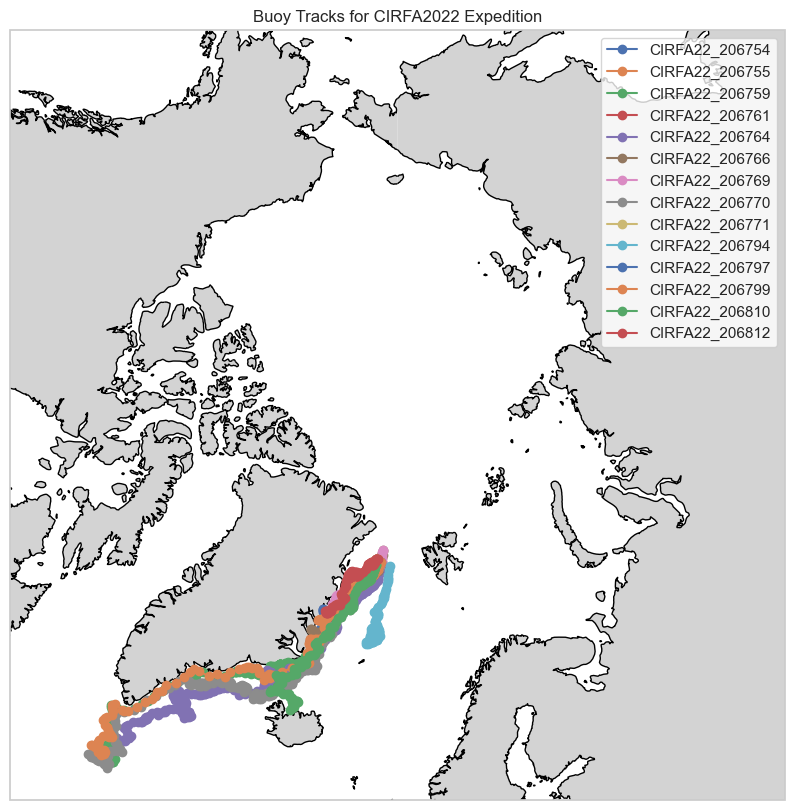

In [139]:
def plot_buoy_tracks(expedition_data):
    plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Plot each buoy's track
    for buoy_id, buoy_df in expedition_data.groupby('buoy_id'):
        ax.plot(
            buoy_df['longitude'], buoy_df['latitude'],
            marker='o', label=buoy_id, transform=ccrs.PlateCarree()
        )

    plt.title('Buoy Tracks for CIRFA2022 Expedition')
    plt.legend()
    plt.show()

# Call the function
plot_buoy_tracks(expedition_data)


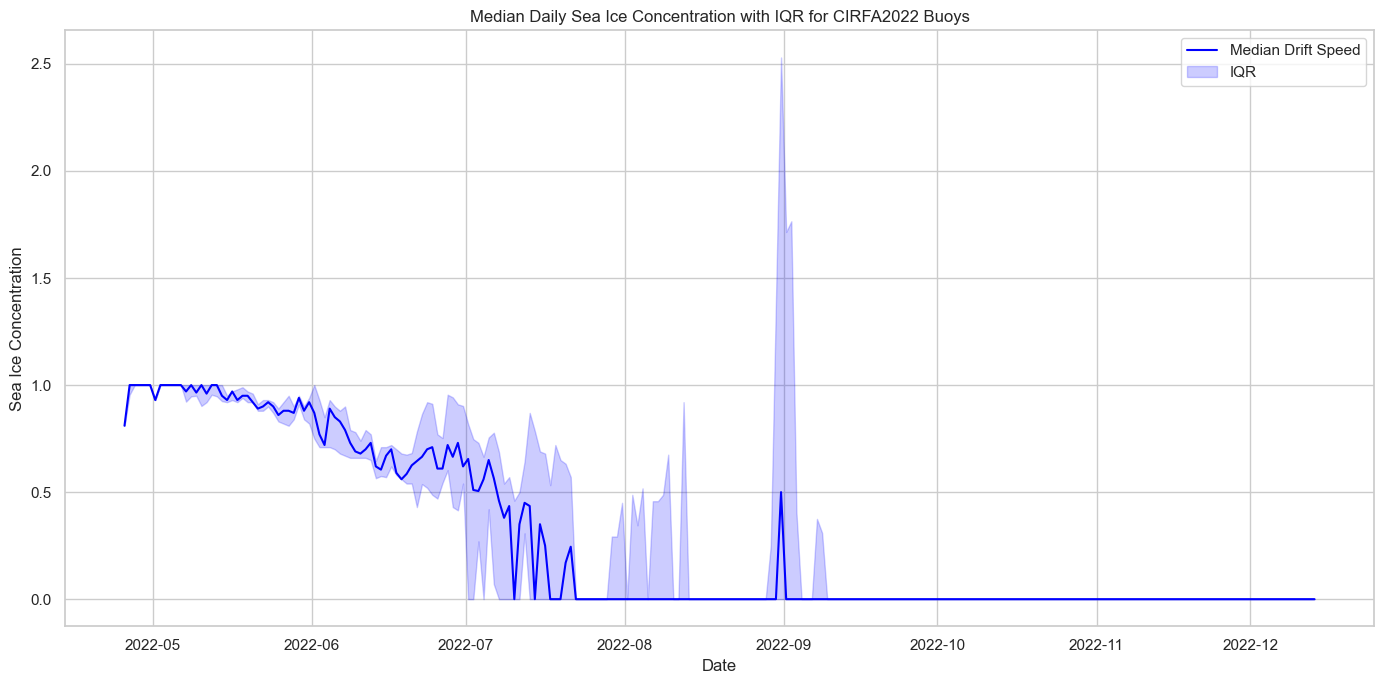

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style
sns.set(style="whitegrid")

# Calculate drift speed statistics
drift_speed_stats = all_positions_daily.groupby('datetime').agg(
    median_speed=('sea_ice_concentration', 'median'),
    IQR_lower=('sea_ice_concentration', lambda x: x.quantile(0.25)),
    IQR_upper=('sea_ice_concentration', lambda x: x.quantile(0.75))
).reset_index()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(drift_speed_stats['datetime'], drift_speed_stats['median_speed'], label='Median Drift Speed', color='blue')
plt.fill_between(
    drift_speed_stats['datetime'],
    drift_speed_stats['IQR_lower'],
    drift_speed_stats['IQR_upper'],
    color='blue',
    alpha=0.2,
    label='IQR'
)
plt.xlabel('Date')
plt.ylabel('Sea Ice Concentration')
plt.title('Median Daily Sea Ice Concentration with IQR for CIRFA2022 Buoys')
plt.legend()
plt.tight_layout()
plt.show()
